In [1]:
import time
import math

import torch
from torch import nn
from torch.nn import functional as F

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.style.use('seaborn')
mpl.rcParams['figure.figsize'] = [10, 10]

## 1 Generating a toy dataset

In [3]:
def generate_disc_set(nb: int, normalize=False):

    input = torch.empty((nb, 2), dtype=torch.float32).uniform_(-1, 1)
    target = (input.pow(2).sum(dim=1) < (2 / math.pi)).type(torch.int64)

    if normalize:
        input.sub_(input.mean()).div_(input.std())

    return input, target

In [4]:
input, target = generate_disc_set(1000, normalize=False)

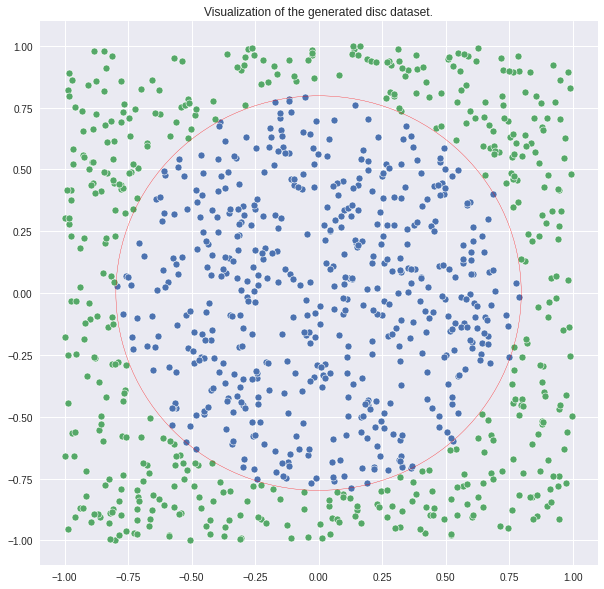

In [5]:
fig, ax = plt.subplots()

sns.scatterplot(x=input[target == 1, 0], y=input[target == 1, 1], ax=ax)
sns.scatterplot(x=input[target == 0, 0], y=input[target == 0, 1], ax=ax)

circle1 = plt.Circle((0, 0), math.sqrt(2 / math.pi), color='r', fill=False)
ax.add_patch(circle1)

ax.set_title("Visualization of the generated disc dataset.")
plt.show()

In [6]:
# Sanity check
print(f"Postive labels represent {100 * sum(target == 1) / target.size(0):.3f} % of the dataset.")

Postive labels represent 51.500 % of the dataset.


## 2 Training and test

In [7]:
def train_model(model: torch.nn.Module, train_input: torch.tensor, train_target: torch.tensor, batch_size=100, eta=1e-1):

    acc_loss = 0
    criterion = torch.nn.CrossEntropyLoss()

    for b in range(0, train_input.size(0), batch_size):

    output = model(train_input[b:b+batch_size])
    loss = criterion(output, train_target[b:b+batch_size])
    acc_loss = acc_loss + loss.item()

    model.zero_grad()
    loss.backward()

    with torch.no_grad():
        for p in model.parameters(): 
            p -= eta * p.grad

    return acc_loss

In [8]:
def compute_nb_errors(model: torch.nn.Module, data_input: torch.tensor, data_target: torch.tensor, batch_size=100):
  
    batch_size = 100
    nb_errors = 0
  
    for b in range(0, data_input.size(0), batch_size):

        out = model(data_input[b:b+batch_size])
        predicted_classes = out.argmax(1)

    for k in range(batch_size):
        if data_target[b + k] != predicted_classes[k]:
            nb_errors += 1

    return nb_errors

## 3 Models

In [9]:
def create_shallow_model():

    return nn.Sequential(
        nn.Linear(2, 128),
        nn.ReLU(),
        nn.Linear(128, 2)
    )

In [10]:
def create_deep_model():

    return nn.Sequential(
        nn.Linear(  2,   4),
        nn.ReLU(),
        nn.Linear(  4,   8),
        nn.ReLU(),
        nn.Linear(  8,  16),
        nn.ReLU(),
        nn.Linear( 16,  32),
        nn.ReLU(),
        nn.Linear( 32,  64),
        nn.ReLU(),
        nn.Linear( 64, 128),
        nn.ReLU(),
        nn.Linear(128,   2),
    )

## 4 Benchmarking

In [11]:
train_input, train_target = generate_disc_set(1000, normalize=True)
# Normalize with training set mean and std
test_input, test_target = generate_disc_set(1000, normalize=True)

In [12]:
shallow = create_shallow_model()
deep    = create_deep_model()

In [13]:
epochs = 250
batch_size = 100
eta = 1e-1

stats = {}

for index, model in enumerate([shallow, deep]):

    key = 'shallow' if index == 0 else 'deep'

    stats[key] = {}

    for init_std in [1e-3, 1e-2, 1e-1, 1, 10]:

        stats[key][init_std] = {}
        stats[key][init_std]['loss']  = []
        stats[key][init_std]['train'] = []
        stats[key][init_std]['test']  = []

        with torch.no_grad():
            for p in shallow.parameters():
                p.normal_(0, init_std) 

        for e in range(epochs):
            loss    = train_model(model, train_input, train_target, batch_size, eta)
            train_e = compute_nb_errors(shallow, train_input, train_target, batch_size)
            test_e  = compute_nb_errors(shallow, test_input, test_target, batch_size)

            stats[key][init_std]['loss' ].append(loss)
            stats[key][init_std]['train'].append(100. - 100. * train_e / float(train_input.size(0)))
            stats[key][init_std]['test' ].append(100. - 100. * test_e / float(test_input.size(0)))

            # print(f"{e:03} \t Loss: {loss:3.3f} \
            #   Train accuracy: {100 - 100 * train_e / train_input.size(0):.3f} % \
            #   Test accuracy: {100 - 100 * test_e / test_input.size(0):.3f} %")

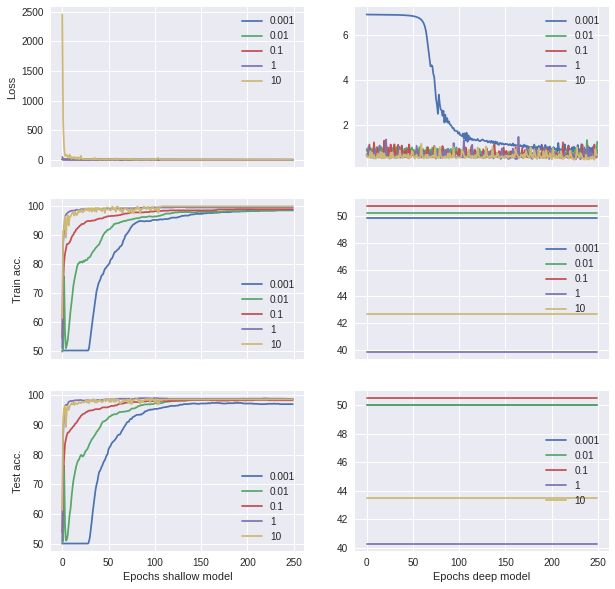

In [14]:
fig, axes = plt.subplots(3, 2, sharex=True)

for m, model in enumerate(['shallow', 'deep']):
    for s, std in enumerate([1e-3, 1e-2, 1e-1, 1, 10]):
        for l, line in enumerate(['loss', 'train', 'test']):

            sns.lineplot(x=list(range(250)), y=stats[model][std][line], label=str(std), ax=axes[l, m])

axes[0, 0].set_ylabel('Loss')
axes[1, 0].set_ylabel('Train acc.')
axes[2, 0].set_ylabel('Test acc.')
axes[2, 0].set_xlabel('Epochs shallow model')
axes[2, 1].set_xlabel('Epochs deep model')

plt.show()